# Imports

In [30]:
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from keras.initializers import Constant
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from keras.utils import plot_model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tabulate

import warnings
warnings.filterwarnings(action='ignore')

# Data preprocessing

In [31]:
# Read data
filepath = r'C:\Idan\OpenU\כריית מידע\mmn21\Chronic_Kidney_Disease\Chronic_Kidney_Disease\chronic_kidney_disease_full.arff'
data = []
with open(filepath, "r") as f:
    data = [line.strip().split(',') for line in f]

columns = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
           'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm',
           'cad', 'appet', 'pe', 'ane', 'class', 'to_delete']
# Data starts from 145 and end 2 lines before the end
ckd_df = pd.DataFrame(data[145:-2], columns=columns)
# drop 'to_delete' column
ckd_df = ckd_df.drop(['to_delete'] ,axis=1)

# Data Cleaning

In [32]:
# Separate categorical and numeric columns
numeric_columns = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
categorical_columns = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']

# Replace missing values with nan
ckd_df = ckd_df.replace({'?': np.nan,
                         'yes': 1, 'no': 0,
                         'ckd': 1, 'notckd': 0,
                         'good': 1, 'poor': 0,
                         'normal': 1, 'abnormal': 0,
                         'present': 1, 'notpresent': 0,
                         '' : np.nan})

# delete rows with more than 9 missing values (remove 11 rows)
ckd_df = ckd_df.dropna(thresh=9)

# Convert Numeric columns to numeric
ckd_df[numeric_columns] = ckd_df[numeric_columns].apply(pd.to_numeric)
# Convert categorical columns to category
ckd_df[categorical_columns] = ckd_df[categorical_columns].apply(lambda x: x.astype('category'))

# splitting the dataset to X and y
X = ckd_df.drop(['class'], axis=1)
y = ckd_df['class']

# remove 'class' from categorical columns
categorical_columns.remove('class')

# After view the Q-Q plot, we can see that there are some outliers in the data
# Remove outliers rows of each feature of numeric columns.
# After it, Use KnnImputer to reassign them again
X.loc[X['bp'] >= 180, 'bp'] = np.nan
X.loc[X['bu'] > 241, 'bu'] = np.nan
X.loc[X['sc'] >= 20, 'sc'] = np.nan
X.loc[X['sc'] >= 100, 'sod'] = np.nan
X.loc[X['sod'] > 150, 'sod'] = np.nan
X.loc[X['sod'] <= 104, 'sod'] = np.nan
X.loc[X['wc'] >= 16_700, 'wc'] = np.nan
X.loc[X['bgr'] < 70, 'bgr'] = np.nan

# Split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=ckd_df['class'])

# Use StandardScaler on numeric columns to scale them to be in the range of 0-1
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Use MinMaxScaler on numeric columns for mean and standard deviation normalization to mean=0 and std=1
scaler = MinMaxScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Impute missing values of numeric columns with SimpleImputer
simple_imputer = SimpleImputer(strategy='mean')
X_train[numeric_columns] = simple_imputer.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = simple_imputer.transform(X_test[numeric_columns])


# Impute missing values of numeric columns with KNNImputer
# knn_imputer = KNNImputer(n_neighbors=5)
# X_train[numeric_columns] = knn_imputer.fit_transform(X_train[numeric_columns])
# X_test[numeric_columns] = knn_imputer.transform(X_test[numeric_columns])

# Use SimpleImputer to impute missing categorical features
simple_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_columns] = simple_imputer.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = simple_imputer.transform(X_test[categorical_columns])

# KBinsDiscretizer Explanation:
# Bin continuous data into intervals and transform them with ordinal encoding. (it's a Combination of binning and encoding)
# Parameters:
#            n_bins: The number of bins to produce.
#            encode='ordinal': Encode the transformed result with values between 0 and n_bins-1.
#            strategy='quantile': Equal depth binning. The quantile strategy produces bins that have the same number of records in each bin.
#            strategy='uniform': Equal width binning. The width of each bin is (max - min) / n_bins.
# Binning age column to 5 equal-depth bins
k_bins_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_train['age'] = k_bins_discretizer.fit_transform(X_train[['age']])
X_test['age'] = k_bins_discretizer.transform(X_test[['age']])
# Binning numeric columns 3 bins with equal width
binning_columns_with_a_lot_of_values = ['bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
k_bins_discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
for col in binning_columns_with_a_lot_of_values:
    X_train[col] = k_bins_discretizer.fit_transform(X_train[[col]])
    X_test[col] = k_bins_discretizer.transform(X_test[[col]])

# Convert numeric columns to category
X_train[numeric_columns] = X_train[numeric_columns].apply(lambda x: x.astype('category'))
X_test[numeric_columns] = X_test[numeric_columns].apply(lambda x: x.astype('category'))

# Select K best features (score_func options are: f_classif, mutual_info_classif, chi2, f_regression, mutual_info_regression)
k_best = SelectKBest(k=15, score_func=f_classif)
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)


# Cluster Analysis
(using PCA for nice view in 2d graph)

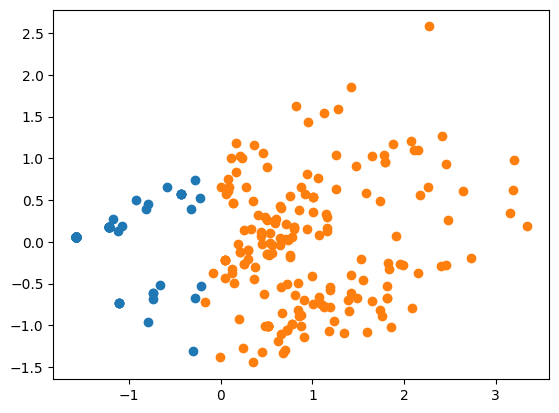

clustering: {0: 136, 1: 184}
real labels: {0: 120, 1: 200}
number of not matching labels: 16


In [33]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# After testing 10 clusters, I found k means is the best cluster.
# define the kmeans model
kmeans_model = KMeans(n_clusters=2)
# fit the kmeans model
yhat = kmeans_model.fit_predict(X_train_pca)
# retrieve unique clusters
clusters = np.unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(X_train_pca[row_ix, 0], X_train_pca[row_ix, 1])
# show the plot
plt.show()
unique, counts = np.unique(kmeans_model.labels_, return_counts=True)
print(f'clustering: {dict(zip(unique, counts))}')
# print the real labels counts
unique, counts = np.unique(y_train, return_counts=True)
print(f'real labels: {dict(zip(unique, counts))}')

# validate that the clustering is good by comparing the real labels with the clustering labels
# compare the real labels with the clustering labels
df = pd.DataFrame({'clustering': kmeans_model.labels_, 'real': y_train.to_numpy()})
# count number of not matching labels
print(f'number of not matching labels: {df[df["clustering"] != df["real"]].shape[0]}')


#### Define helper functions for later

In [34]:

# Define a function to calculate the Mean Squared Error
def mean_squared_error(y_true, y_pred):
    # convert y_true to numeric type
    y_true = y_true.astype(np.float64)
    return np.mean((y_true - y_pred) ** 2)

# Define a function to display the ROC curve and calculate the AUC score
def plot_roc_curve(y_pred_proba_train, y_pred_proba_test, y_train, y_test, model_name):
    # Calculate ROC curves and AUC scores for both training and test sets
    # y_pred_proba_train = rfc_model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    auc_train = roc_auc_score(y_train, y_pred_proba_train)

    # y_pred_proba_test = rfc_model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
    auc_test = roc_auc_score(y_test, y_pred_proba_test)

    # Plot the ROC curves for both training and test sets
    plt.plot(fpr_train, tpr_train, label=f"Training set, auc={auc_train}")
    plt.plot(fpr_test, tpr_test, label=f"Test set, auc={auc_test}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random classifier')
    # Title
    plt.title(f'ROC Curve of {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Naive Bayes 

Naive Bayes 10-Cross Validation Results:
+--------+----------------+---------------+
|   Fold |   Train scores |   Test scores |
|--------+----------------+---------------|
|      1 |       0.986111 |       0.96875 |
|      2 |       0.982639 |       1       |
|      3 |       0.989583 |       0.9375  |
|      4 |       0.986111 |       0.96875 |
|      5 |       0.982639 |       1       |
|      6 |       0.986111 |       0.96875 |
|      7 |       0.982639 |       1       |
|      8 |       0.982639 |       1       |
|      9 |       0.982639 |       1       |
|     10 |       0.993056 |       0.90625 |
+--------+----------------+---------------+
Mean train score: 0.9854166666666666
Mean test score: 0.975
Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  116 |                    4 |
|

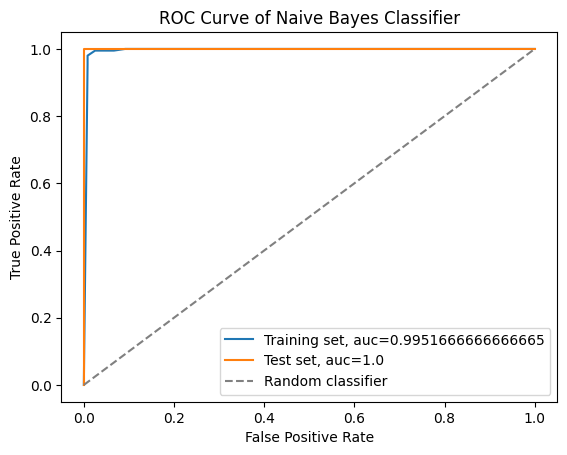

Mean Squared Error: 0.0
Test score: 1.0


In [35]:

# # Search for the best parameters for Naive Bayes Classifier
# nb_classifier = GaussianNB()
#
# params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
# gs_NB = GridSearchCV(estimator=nb_classifier,
#                  param_grid=params_NB,
#                  cv=10,
#                  verbose=1,
#                  scoring='accuracy')
# gs_NB.fit(X_train, y_train)
# gs_NB.best_params_

# Initialize the Naive Bayes Classifier
naive_bayes_model = GaussianNB(var_smoothing=0.004328761281083057)

# Perform cross validation with 10 folds with sklearn class
naive_bayes_k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
naive_bayes_k_fold.get_n_splits(X_train)
folds_y_tests, predictions_of_all_folds = [], []
train_scores, test_scores = [], []
confusion_matrix_list = []
for train_index, test_index in naive_bayes_k_fold.split(X_train):
    # Define the train and test sets for each fold
    X_train_k_fold, X_test_k_fold = X_train[train_index], X_train[test_index]
    y_train_k_fold, y_test_k_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    # Fit the model and predict of current fold
    naive_bayes_model.fit(X_train_k_fold, y_train_k_fold)
    # Calculate the scores on test set
    y_pred = naive_bayes_model.predict(X_test_k_fold)
    # Append the y_test and y_pred to the lists for the classification report
    folds_y_tests.extend(y_test_k_fold)
    predictions_of_all_folds.extend(y_pred)
    # Append the scores to the lists
    train_scores.append(naive_bayes_model.score(X_train_k_fold, y_train_k_fold))
    test_scores.append(naive_bayes_model.score(X_test_k_fold, y_test_k_fold))
    confusion_matrix_list.append(confusion_matrix(y_test_k_fold, y_pred))

# Print the train and test scores with a column of the number of fold
print('Naive Bayes 10-Cross Validation Results:')
print(tabulate.tabulate({'Fold': range(1, 11),
                         'Train scores': train_scores,
                         'Test scores': test_scores}, headers='keys', tablefmt='psql'))

# Print the mean of the train and test scores
print(f'Mean train score: {np.mean(train_scores)}')
print(f'Mean test score: {np.mean(test_scores)}')

# Sum all the confusion matrices from the cross validation
confusion_matrix_sum = np.sum(confusion_matrix_list, axis=0)

# Print the confusion matrix with tabulate
print('Confusion Matrix:')
print(tabulate.tabulate({'': ['Actual Positive', 'Actual Negative'],
                            'Predicted Positive': [confusion_matrix_sum[0][0], confusion_matrix_sum[0][1]],
                            'Predicted Negative': [confusion_matrix_sum[1][0], confusion_matrix_sum[1][1]]},
                            headers='keys',
                            tablefmt='psql'))

# Print the classification report for the sum of the folds predictions
print('Classification Report of all folds:')
print(classification_report(folds_y_tests, predictions_of_all_folds))

# Display the ROC curve of the Naive Bayes Classifier for comparing between the train and test sets
naive_bayes_model.fit(X_train, y_train)
y_pred_proba_train = naive_bayes_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = naive_bayes_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_pred_proba_train, y_pred_proba_test, y_train, y_test, 'Naive Bayes Classifier')

# Predict the test set
y_pred = naive_bayes_model.predict(X_test)

# Calculate the Mean Squared Error of the cross validation
mse_naive_bayes = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mean_squared_error(y_test, naive_bayes_model.predict(X_test))}')

# print test score of the test set (not cross validation)
print(f'Test score: {naive_bayes_model.score(X_test, y_test)}')



# K Nearest Neighbors

KNN 10-Cross Validation Results:
+--------+----------------+---------------+
|   Fold |   Train scores |   Test scores |
|--------+----------------+---------------|
|      1 |       0.972222 |       1       |
|      2 |       0.975694 |       0.96875 |
|      3 |       0.975694 |       0.96875 |
|      4 |       0.972222 |       1       |
|      5 |       0.972222 |       1       |
|      6 |       0.972222 |       0.96875 |
|      7 |       0.972222 |       1       |
|      8 |       0.975694 |       0.96875 |
|      9 |       0.975694 |       0.96875 |
|     10 |       0.982639 |       0.90625 |
+--------+----------------+---------------+
Mean train score: 0.9746527777777777
Mean test score: 0.975
Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Positive |   Predicted Negative |
|-----------------+----------------------+----------------------|
| Actual Positive |                  118 |                    6 |
| Actual 

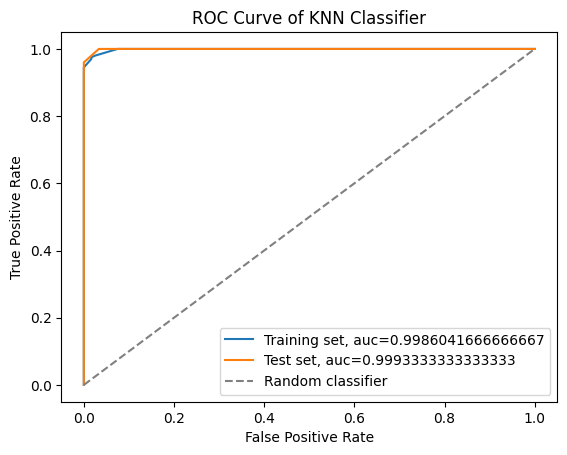

Mean Squared Error: 0.0125
Test score: 0.9875
+----+-------------+----------------------+--------------+
|    | Model       |   Mean Squared Error |   Test Score |
|----+-------------+----------------------+--------------|
|  0 | Naive Bayes |               0      |       1      |
|  1 | KNN         |               0.0125 |       0.9875 |
+----+-------------+----------------------+--------------+


In [36]:
# Search for the best parameters for KNN Classifier
knn_classifier = KNeighborsClassifier()

# params_KNN = {'n_neighbors': np.arange(1, 25)}
# gs_KNN = GridSearchCV(estimator=knn_classifier,
#                  param_grid=params_KNN,
#                  cv=10,
#                  verbose=1,
#                  scoring='accuracy')
# gs_KNN.fit(X_train, y_train)
# gs_KNN.best_params_

# Initialize the KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=9)

# Perform cross validation with 10 folds with sklearn class
knn_k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
knn_k_fold.get_n_splits(X_train)
folds_y_tests, predictions_of_all_folds = [], []
train_scores, test_scores = [], []
confusion_matrix_list = []
for train_index, test_index in knn_k_fold.split(X_train):
    # Define the train and test sets for each fold
    X_train_k_fold, X_test_k_fold = X_train[train_index], X_train[test_index]
    y_train_k_fold, y_test_k_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    # Fit the model and predict of current fold
    knn_model.fit(X_train_k_fold, y_train_k_fold)
    # Calculate the scores on test set
    y_pred = knn_model.predict(X_test_k_fold)
    # Append the y_test and y_pred to the lists for the classification report
    folds_y_tests.extend(y_test_k_fold)
    predictions_of_all_folds.extend(y_pred)
    # Append the scores to the lists
    train_scores.append(knn_model.score(X_train_k_fold, y_train_k_fold))
    test_scores.append(knn_model.score(X_test_k_fold, y_test_k_fold))
    confusion_matrix_list.append(confusion_matrix(y_test_k_fold, y_pred))

# Print the train and test scores with a column of the number of fold
print('KNN 10-Cross Validation Results:')
print(tabulate.tabulate({'Fold': range(1, 11),
                            'Train scores': train_scores,
                            'Test scores': test_scores}, headers='keys', tablefmt='psql'))

# Print the mean of the train and test scores
print(f'Mean train score: {np.mean(train_scores)}')
print(f'Mean test score: {np.mean(test_scores)}')

# Sum all the confusion matrices from the cross validation
confusion_matrix_sum = np.sum(confusion_matrix_list, axis=0)

# Print the confusion matrix with tabulate
print('Confusion Matrix:')
print(tabulate.tabulate({'': ['Actual Positive', 'Actual Negative'],
                            'Predicted Positive': [confusion_matrix_sum[0][0], confusion_matrix_sum[0][1]],
                            'Predicted Negative': [confusion_matrix_sum[1][0], confusion_matrix_sum[1][1]]},
                            headers='keys',
                            tablefmt='psql'))

# Print the classification report for the sum of the folds predictions
print('Classification Report of all folds:')
print(classification_report(folds_y_tests, predictions_of_all_folds))

# Display the ROC curve of the KNN Classifier for comparing between the train and test sets
knn_model.fit(X_train, y_train)
y_pred_proba_train = knn_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = knn_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_pred_proba_train, y_pred_proba_test, y_train, y_test, 'KNN Classifier')

# Predict the test set
y_pred = knn_model.predict(X_test)

# Calculate the Mean Squared Error of the cross validation
mse_knn = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mean_squared_error(y_test, knn_model.predict(X_test))}')

# print test score of the test set (not cross validation)
print(f'Test score: {knn_model.score(X_test, y_test)}')


# Create a dataframe of the models and their scores
models_df = pd.DataFrame({'Model': ['Naive Bayes', 'KNN'],
                          'Mean Squared Error': [mse_naive_bayes, mse_knn],
                          'Test Score': [naive_bayes_model.score(X_test, y_test), knn_model.score(X_test, y_test)]})
# Print the dataframe
print(tabulate.tabulate(models_df, headers='keys', tablefmt='psql'))

# Neural Network

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<Figure size 640x480 with 0 Axes>

Epoch 1/50
64/64 [==============================] - 2s 10ms/step - loss: 0.6572 - accuracy: 0.7812 - val_loss: 0.6137 - val_accuracy: 0.9000
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5855 - accuracy: 0.9094 - val_loss: 0.5136 - val_accuracy: 0.9750
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 0.4692 - accuracy: 0.9500 - val_loss: 0.3811 - val_accuracy: 0.9875
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 0.3501 - accuracy: 0.9312 - val_loss: 0.2715 - val_accuracy: 0.9875
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 0.2605 - accuracy: 0.9344 - val_loss: 0.1906 - val_accuracy: 0.9875
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: 0.1968 - accuracy: 0.9469 - val_loss: 0.1350 - val_accuracy: 1.0000
Epoch 7/50
64/64 [==============================] - 0s 4ms/step - loss: 0.1560 - accuracy: 0.9594 - val_loss: 0.1029 - val_accuracy: 1.0000
Epoch 8/50
64/64 [=

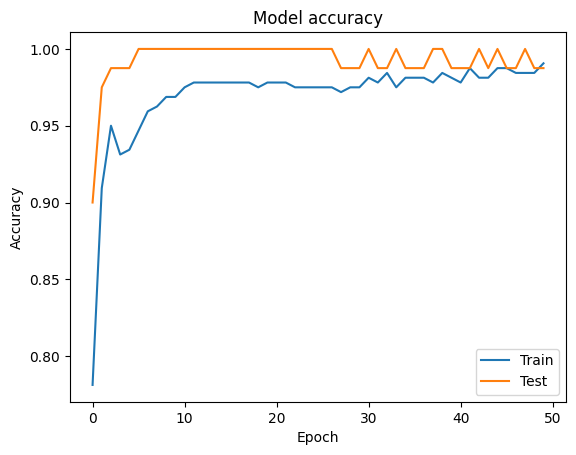

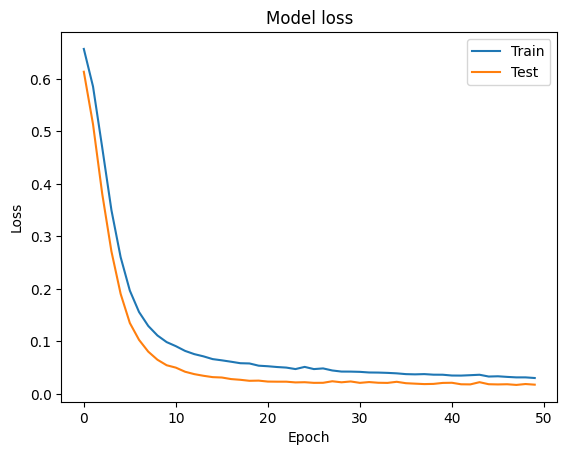

3/3 [==============================] - 0s 3ms/step
Misclassified samples: [27]
Train Accuracy: 0.9906250238418579
Test Accuracy: 0.987500011920929
Done


In [37]:
model = Sequential()
model.add(Dense(12, input_shape=(15,), activation='relu', bias_initializer='zeros', kernel_initializer='he_uniform'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# configure the adam optimizer
adam_optimizer = Adam(learning_rate=0.001)
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
# Plot the model architecture
plt.figure()
plot_model(model, to_file='C:\Idan\OpenU\כריית מידע\mmn22\model.png', show_shapes=True, show_layer_names=True)
plt.show()

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=5, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

y_true = y_test.values
# Predicting the Test set results
y_pred = model.predict(X_test)
# y_pred = (y_pred > 0.5)
y_pred = np.round(y_pred)
# Find the misclassified samples
misclassified_indices = np.where(y_true != y_pred.T[0])[0]

# Printing the indices of the misclassified samples
print('Misclassified samples:', misclassified_indices)

# print the model results
print(f'Train Accuracy: {model.evaluate(X_train, y_train, verbose=0)[1]}')
print(f'Test Accuracy: {model.evaluate(X_test, y_test, verbose=0)[1]}')

print('Done')

